[Reference](https://medium.com/geekculture/analyzing-customer-churn-data-with-python-ddfef75e8149)

# Collecting and cleaning the data


In [1]:
# Import libraries
import sklearn as sk
import pandas as pd
import matplotlib as plt
import xgboost as xgb
import seaborn as sn
import matplotlib.pyplot as plt
import os
import numpy as np
# ML algorithms
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
## For hyperperameter tuning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading data
data = pd.read_csv('https://raw.githubusercontent.com/AashiqReza/DataAnalysiswithPython/main/Classification/WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',')
# Overview of the data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Checking the summary of missing values
data.isnull().values.any() # The result false implies there is no missing values in the data

False

In [4]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Removing variables we are not interested in
data.drop(data.columns[[0]], axis = 1, inplace = True)
## Missing values occured in terms of blank spaces in this dataset
print (data[pd.to_numeric(data.TotalCharges, errors='coerce').isnull()])## Replace all the blank spaces to NA's
nan = float("NaN")
data.replace(" ", nan, inplace=True)
data.dropna(subset = ["TotalCharges", "MonthlyCharges"], inplace=True)
data.MonthlyCharges = pd.to_numeric(data.MonthlyCharges)
data.TotalCharges = pd.to_numeric(data.TotalCharges)

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 N

# Data Visualizations


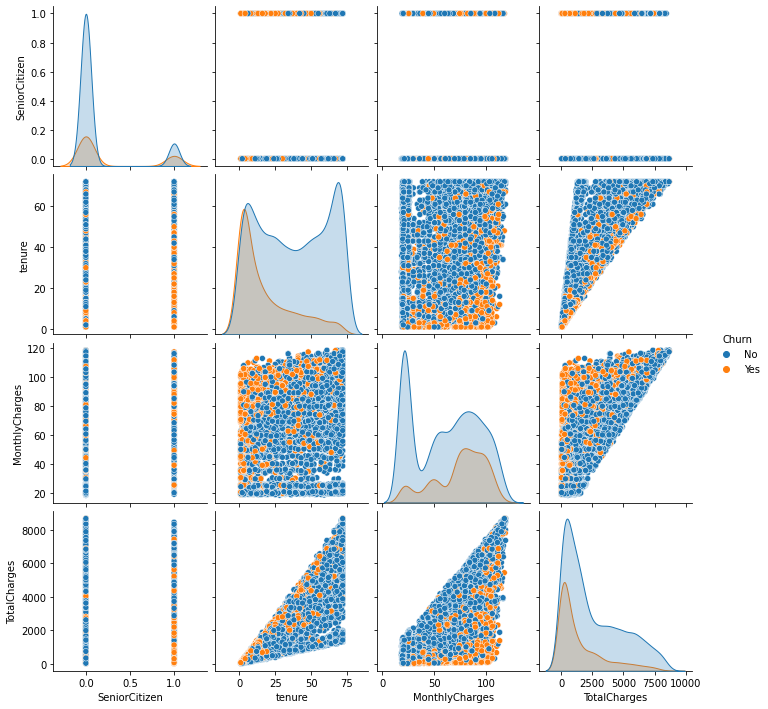

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


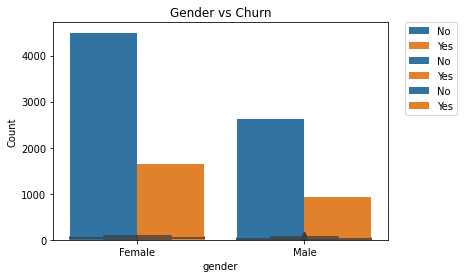

In [6]:
# pairplots
sn.pairplot(data = data, hue='Churn')
plt.show()## Average time to churn
sn.boxplot(data['Churn'], data['tenure'])
plt.title('Tenure vs Churn')# Effect of Contract length on customer attrition
counts = (data.groupby(['Contract'])['Churn']
  .value_counts()
  .rename('Count')
  .reset_index())
sn.barplot(x="Contract", y="Count", hue="Churn", data=counts).set_title('Contract length vs Churn')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)# Effect of age on customer attrition
counts = (data.groupby(['SeniorCitizen'])['Churn']
  .value_counts()
  .rename('Count')
  .reset_index())
sn.barplot(x="SeniorCitizen", y="Count", hue="Churn", data=counts).set_title('SeniorCitizen vs Churn')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('fig4.png')# Effect of Contract length on customer attrition
counts = (data.groupby(['gender'])['Churn']
  .value_counts()
  .rename('Count')
  .reset_index())
sn.barplot(x="gender", y="Count", hue="Churn", data=counts).set_title('Gender vs Churn')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('fig5.png')

# Modeling and Accuracy Test


In [7]:
# Splitting into test and train sets
x = data.drop('Churn', axis=1)
y = data['Churn']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [8]:
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)
predictions = logmodel.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1555
         Yes       0.65      0.53      0.58       555

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.73      2110
weighted avg       0.79      0.80      0.79      2110

[[1395  160]
 [ 260  295]]
0.8009478672985783


In [9]:
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

          No       0.86      0.85      0.85      1555
         Yes       0.58      0.61      0.59       555

    accuracy                           0.78      2110
   macro avg       0.72      0.73      0.72      2110
weighted avg       0.79      0.78      0.78      2110

[[1315  240]
 [ 219  336]]
0.7824644549763033


In [10]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)
predictions = dtree.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

          No       0.82      0.80      0.81      1555
         Yes       0.48      0.51      0.49       555

    accuracy                           0.72      2110
   macro avg       0.65      0.66      0.65      2110
weighted avg       0.73      0.72      0.73      2110

[[1242  313]
 [ 270  285]]
0.723696682464455


In [11]:
rand = RandomForestClassifier()
rand.fit(x_train, y_train)
predictions = rand.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

          No       0.83      0.89      0.86      1555
         Yes       0.62      0.49      0.54       555

    accuracy                           0.79      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.79      0.78      2110

[[1386  169]
 [ 284  271]]
0.7853080568720379


# Hyperparameter tuning


In [12]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.logspace(-4, 4, 50)
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = [1000])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logmodel, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.807326 using {'C': 0.013257113655901081, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
